## Project :  Analyze A/B Test Results
### By Somya Bharti

In this project, I will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Here, I'll help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusions](#conclusions)


<a id='intro'></a>
### Introduction

A/B testing (also known as split testing or bucket testing) is a method of comparing two versions of a webpage or app against each other to determine which one performs better. AB testing is essentially an experiment where two or more variants of a page are shown to users at random, and statistical analysis is used to determine which variation performs better for a given conversion goal.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

### Gathering Data

In [2]:
df=pd.read_csv('ab_data.csv')

In [3]:
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


- Number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

- Number of unique users in the dataset.

In [5]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

- The proportion of users converted.

> We will find the number of people converted to total number of people.

In [6]:
len(df[df['converted'] == 1])/df.shape[0]

0.11965919355605512

- The number of times the `new_page` and `treatment` don't line up.

> For this, there can be two cases.
- First when the treatment group lands on an old page instead of new page.
- Second, when the control group lands on new page instead of old page.

In [7]:
q1=df.query ('group == "treatment" and landing_page == "old_page"').shape[0]

In [8]:
q2=df.query ('group == "control" and landing_page == "new_page"').shape[0]

In [9]:
q1+q2

3893

> Let's find the missing values

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


- As we see that total number of rows are 294478 and each column consists of 294478 entries, there are no missing values in the dataset.

> For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

- We should only use the rows that we can feel confident in the accuracy of the data so we will drop the rows wherever there is misalignment.



In [11]:
df2 = df.drop(df[((df.landing_page == 'new_page') & (df.group == 'control')) |
                 ((df.landing_page == 'old_page') & (df.group == 'treatment'))].index)



In [12]:
df2.shape

(290585, 5)

In [13]:

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

 > Unique **user_id**s are in **df2**

In [14]:
df2.nunique().user_id

290584

> As we see that total number of users are 290585 and unique users are 290584, we need to find the duplicate user id and remove it from our dataset. 

In [15]:
ids = df2["user_id"]
ids.duplicated().sum()

1

> Row information for the repeat **user_id**

In [16]:
df2[ids.isin(ids[ids.duplicated()])]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


> Removed **one** of the rows with a duplicate **user_id**.

In [17]:
df2 = df2[~df2.user_id.duplicated(keep='first')]
 

In [18]:
df2.shape

(290584, 5)

> Probability of an individual converting regardless of the page they receive.

- Sum of people converted

In [19]:
(df2.converted==1).sum()

34753

- Sum of people didn't convert

In [20]:
(df2.converted==0).sum()

255831

- Probability

In [21]:
(df2.converted==1).mean()

0.11959708724499628

>Probability they converted such that an individual was in the `control` group.

In [22]:
control_=df2.converted[df2.group=='control'].mean()
control_

0.1203863045004612

>Probability they converted such that an individual was in the `treatment` group.

In [23]:
treatment_=df2.converted[df2.group=='treatment'].mean()
treatment_

0.11880806551510564

> Now, we will find the difference between the people under treatment group who converted and people under control group who converted.

In [24]:
observed_diff = treatment_ - control_
observed_diff


-0.0015782389853555567

>Probability that an individual received the new page

In [25]:
p_new_page=len(df2[df2['landing_page'] == "new_page"])/df2.shape[0]
p_new_page

0.5000619442226688

>Probability that an individual received the old page

In [26]:
1-p_new_page

0.4999380557773312

### Observations from the above statistics :

**The probability of an individual of control group converting is 0.12 whereas the probability of an individual of treatment group converting is 0.11. Also, the probability of an individual landing on a new page is 0.5 which is not more when compared to landing on old page. Hence, we observe that there is no such vast difference between the treatment group and control group to conculde which page is better for increasing convert rate.**

<a id='ab_test'></a>
## Part II - A/B Test


> Now, we will make the decision just based on all the data provided.For this, we will perform hypothesis testing to check whether our calculated observations are right or not. For performing this test we consider two types of Hypothesis that is Null and Alternative Hypothesis.

- Null Hypothesis(**$p_{old}$**) - The probability of coversion on old page is better than new page. (P_old > P_new)

- Alternative Hypothesis( **$p_{new}$**) - The probability of conversion on new page is better. 
(P_new > P_old) which implies P_old  -  P_new < 0

Now, we will assume that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assumed that they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>




> **Convert rate** for $p_{new}$ under the null

In [27]:
p_new=df2['converted'].mean()
p_new

0.11959708724499628

> **Convert rate** for $p_{old}$ under the null

In [28]:
p_old=df2['converted'].mean()
p_old

0.11959708724499628

> $n_{new}$

In [29]:
n_new=len(df2[df2['landing_page'] == "new_page"])
n_new

145310

 $n_{old}$

In [30]:
n_old=len(df2[df2['landing_page'] == "old_page"])
n_old

145274

Now we will simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null using random choice.

In [31]:
new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
new_page_converted.mean()

0.12141628243066548

> Simulated $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. 

In [32]:
old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
old_page_converted.mean()

0.11885127414403128

>Now we will find $p_{new}$ - $p_{old}$ for our simulated values.

In [33]:
new_page_converted.mean()-old_page_converted.mean()

0.002565008286634196

>Now we will use a sample size for each page equal to the ones in **ab_data.csv** and perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  

Stored all 10,000 values in a numpy array called **p_diffs**.

In [34]:
# create sampling distribution of difference with boostrapping 

p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
    old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    

In [35]:
p_diffs[:10]

[-2.9990670279811393e-05,
 0.0019181137314928237,
 0.000624113155094197,
 0.000720373630081747,
 -0.0010210436762921188,
 -0.0012204106522845926,
 -0.0011172325256597615,
 -0.0003876638145076383,
 -0.00016057336543701117,
 -3.6650810759805696e-05]

>Histogram of the **p_diffs**. 

In [36]:
p_diffs = np.array(p_diffs)

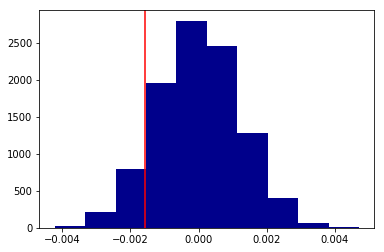

In [37]:
plt.hist(p_diffs,color='#00008b');
plt.axvline(observed_diff, c='r')

Proportion of the **p_diffs** when they are greater than the actual difference observed in **ab_data.csv**

In [38]:
(p_diffs>observed_diff).mean()

0.9023

>### Obsevations from the above plot:
- The proportion is which we just calculated above is p-value.The p-value is the probability of getting our statistic or a more extreme value if the null is true.
- Therefore, small p-values suggest our null is not true. Our statistic is likely to have come from a different distribution than the null.
- When the p-value is large, we have evidence that our statistic was likely to come from the null hypothesis. Therefore, we do not have evidence to reject the null.
- **In this project, we have taken Type 1 error into consideration for which alpha value is 0.05.
Here our calculated p-value is 0.9065 which is too large than alpha value. So we, cannot reject the null hypothesis in this case.**

> We can also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.
- Below we have calculated the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [39]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"')['converted'].count()
n_new = df2.query('landing_page == "new_page"')['converted'].count()

> Used `stats.proportions_ztest` to compute our test statistic and p-value.  

In [40]:
from statsmodels.stats.proportion import proportions_ztest
z, pval = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative='smaller')
z,pval


(1.3109241984234394, 0.9050583127590245)

In [41]:
from scipy.stats import norm
norm.ppf(1-(0.05/2))

1.959963984540054

> ### Observations from z-score and p-value:
- The value of the z-score tells you how many standard deviations you are away from the mean.If a z-score is equal to 0, it is on the mean. If a Z-Score is equal to +1, it is 1 Standard Deviation above the mean. If a z-score is equal to +2, it is 2 Standard Deviations above the mean. 
- Here our z-score is 1.31 which does not exceeds 1.95 that is it provides a clear cut explanation of not rejecting the null hypothesis.
- Our p-value is again 0.905 which is larger than 0.05 and so it denotes the failure of rjecting null hypothesis. 

<a id='regression'></a>
### Part III - A regression approach

- In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

**Here in this case we have only two posiible outcomes, that whether an individual converts or not*.So, for this problem we will be using Logistic Regression.**

>The goal is to use **statsmodels** to fit the regression model  to see if there is a significant difference in conversion based on which page a customer receives.  However,firstly we need to create a column for the intercept, and create a dummy variable column for which page each user received. And then add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [42]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop(['control'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


> Used **statsmodels** to import the logistic regression model.  Instantiated the model, and fit the model using the two columns that is intercept and ab_page to predict whether or not an individual converts.

In [43]:
df2['intercept'] = 1
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


>Summary of the model

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        09:27:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

> ### Observations from the summary :
- In part 2, that is the Hypothesis testing we came to a conclusion that we fail to reject the null hypothesis that was **P_old - P_new > 0** but here in the regression part we found that  **P_old - P_new = 0**
- In case of the alternate hypothesis we defined above was **P_old - P_new < 0** but here in the regression part we found that  **P_old - P_new != 0**.
- Also, the p-value we calculated in part 2 was around 0.9 but here it is 0.19 which is comparatively very less and doesn't fall under the category of 0.05. This is because in part 2 we performed one-sided test whereas in logistic regression we performed two-sided test.
- This contradiction of hypothesis shows that there is no such relation among the independent and dependent variable when we particularly take only two possible outcomes in account.

> ### Factors which can be taken into consideration-
- As studied earlier in the classroom about the A/B tests of the website Audacity, we may take factors such Click through rate, Enrollment rate, Average reading duration into consideration one by one and then analyze them together that is multiple metrics to get correct observations.
- Also, from their gender, age, country where they live, we might be able to see whether conversion rate is better in certain countries or in case of single age categories or between two genders.But there will be some disadvantages as well. The more things that we test, the more likely we are to observe significant differences just by chance. This happens when we run evaluations from multiple metrics at the same time. When we have our x-variables, we want them to be correlated with the response but not each other. When x-variables are related to one another, the result can be very misleading, and it can lead to flipped regression from an expected relationship. This correlation between metrics is called multicollinearity.

> Now along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives.

In [45]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [46]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


> Before creating dummy variables, we need to know how many unique countries are there in the dataset. 

In [47]:
df_new['country'].nunique()

3

> Since there are three unique countries, we will create dummy variables for two countries.

In [48]:
### Create the necessary dummy variables
df_new[['UK', 'US']] = pd.get_dummies(df_new['country'])[['UK','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [49]:
### Fit Your Linear Model And Obtain the Results
df_new[['UK', 'US']] = pd.get_dummies(df_new['country'])[['UK','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [50]:
df_new['intercept'] = 1

logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','UK','US']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [51]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 05 May 2020   Pseudo R-squ.:               1.521e-05
Time:                        09:27:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**Even when we take an individual's destination into consideration, the p-value is not less than 0.05 which clearly suggests that the place of stay is not relaed to the conversion rate.**

> Till now we have looked at the individual factors of country and page on conversion, 
we would now like to look at an interaction between page and country to see if there significant effects on
conversion.    


In [52]:
df_new['US_ab_page'] = df_new['US']*df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK']*df_new['ab_page']

In [56]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US','US_ab_page','UK_ab_page']])

results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Tue, 05 May 2020   Pseudo R-squ.:               2.691e-05
Time:                        09:28:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2205
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0453      0.031      1.481      0.139      -0.015       0.105
US             0.0511      0.028      1.841      0.066      -0.003       0.105
US_ab_page    -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK_ab_page     0.0108      0.023      0.475      0.635      -0.034       0.056
==============================================================================
"""

**Even after analysing multiple metrics that is the landing page and destination, p-value remains greater than 0.05, which shows that these factors do not play any role in determining the conversion rate.Hence,there is no interaction between page and country so that there are significant effects on conversion.**

<a id='conclusions'></a>
## Conclusions:

- In this project, I understood the phases of analysing A/B Tests and decide the factors which help in coming to a proper conculsion.
- The First part was the Probability part where I calculated statistics where I got the conclusion that there is no such increase in the conversion rate irrespective of the group that is either treatment or control in terms of landing page.
- The second part was the A/B test where we performed hypothesis testing and sampling distribution and observed that we cannot accept the null hypothesis as the p-value was much greater than alpha value.
- The third part was the regression part where the tables turned. In this part when we focussed only on outcomes, we came to a conclusion that there was no relation between the dependent and independent variables because p-value was very different from that obtained in part2. Even when we took another factors that is destination then also there wasn't any relation among the variables.

**Hence,we finally conclude that we need to take other factors in consideration for determing the conversion rate like duration and other factors.**